In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def subset(d, ks):
    """
    Takes a subset of dictionary `d`.
    """
    dn = {k: d[k] for k in ks}
    return dn


def calc_index_lag(a, b):
    """
    Naive lag estimation necessary to shift `a` to align with `b`.
    """
    C = len(a)
    assert len(b) == C
    X = np.correlate(a, b, "full")
    # Offset for symmetric, and then handle off-by-one indexing... I guess?
    lag = X.argmax() - C + 1
    return lag


def rms(x):
    return np.sqrt(np.mean(np.square(x), axis=0))


def metrics(x):
    x_abs = np.abs(x)
    return dict(
        mean_abs=np.mean(x_abs, axis=0).tolist(),
        max_abs=np.max(x_abs, axis=0).tolist(),
        rms=rms(x).tolist(),
    )

In [3]:
ndof = 7
base = "./data/2020-11-04T23_35_42-05_00"
files = [f"{base}__A{i+1}.pkl" for i in range(ndof)]
proc_file = f"{base}.processed.pkl"

In [4]:
has_raw = False

if has_raw:

    ts = []
    qa = []
    va = []
    vd = []

    for i, file in enumerate(files):
        with open(file, "rb") as f:
            events = pickle.load(f)

        ts_i = []
        qa_i = []
        va_i = []
        vd_i = []

        t0_abs_usec = events[0][1].utime

        for status, cmd in events:
            t = (cmd.utime - t0_abs_usec) / 1e6
            ts_i.append(t)
            qa_i.append(status.joint_position[i])
            va_i.append(status.joint_velocity[i])
            vd_i.append(cmd.joint_velocity[i])

        ts_i = np.asarray(ts_i)
        qa_i = np.asarray(qa_i)
        va_i = np.asarray(va_i)
        vd_i = np.asarray(vd_i)

        ts.append(ts_i)
        qa.append(qa_i)
        va.append(va_i)
        vd.append(vd_i)

    sub = subset(locals(), ("ts", "qa", "va", "vd", "ndof", "file"))
    with open(proc_file, "wb") as f:
        pickle.dump(sub, f)
    print(proc_file)

else:

    with open(proc_file, "rb") as f:
        sub = pickle.load(f)

    ts, qa, va, vd = map(sub.get, ("ts", "qa", "va", "vd"))

In [5]:
# Copied from `experiment_joints.py`.
t_sweep = 10.0
T_sec_min = 1.0
T_sec_max = 5.0

A1:
  s_chirp: 0.7999882
  T_sec_final: 1.8000471999999998
  freq_final: 0.556 Hz
  d_to_a_suggsted: 2
A2:
  s_chirp: 0.7997287
  T_sec_final: 1.8010852000000002
  freq_final: 0.555 Hz
  d_to_a_suggsted: 2
A3:
  s_chirp: 0.7998387
  T_sec_final: 1.8006452
  freq_final: 0.555 Hz
  d_to_a_suggsted: 2
A4:
  s_chirp: 0.7999727
  T_sec_final: 1.8001092
  freq_final: 0.556 Hz
  d_to_a_suggsted: 2
A5:
  s_chirp: 0.7998046000000001
  T_sec_final: 1.8007815999999996
  freq_final: 0.555 Hz
  d_to_a_suggsted: 2
A6:
  s_chirp: 0.7999487000000001
  T_sec_final: 1.8002051999999997
  freq_final: 0.555 Hz
  d_to_a_suggsted: 2
A7:
  s_chirp: 0.79993
  T_sec_final: 1.8002799999999999
  freq_final: 0.555 Hz
  d_to_a_suggsted: 2


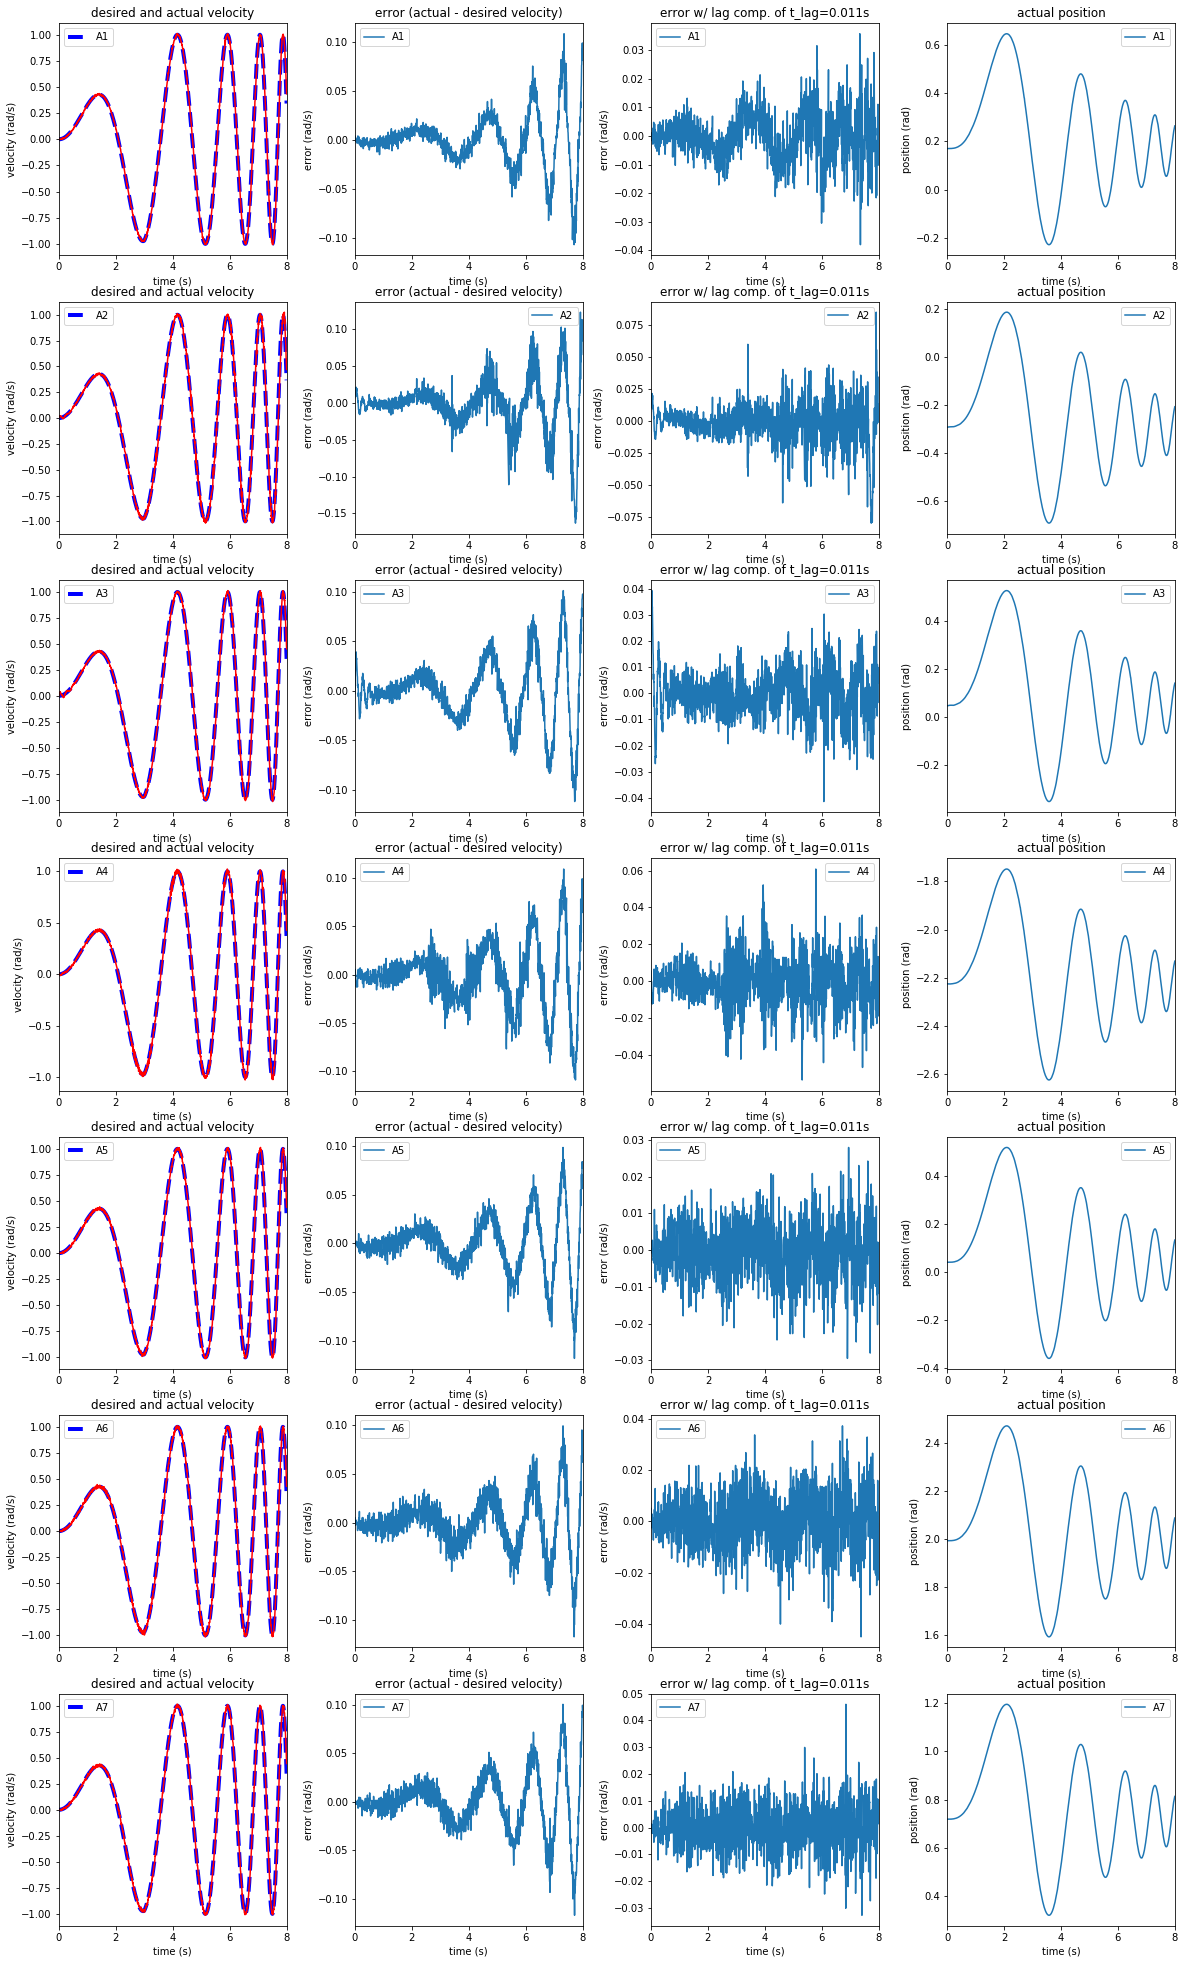

In [7]:
fig, axs = plt.subplots(
    nrows=ndof, ncols=4, squeeze=False, figsize=(20, ndof * 5),
)
plt.subplots_adjust(wspace=0.3)

doc = dict()

for i, ax_col in enumerate(axs):
    name = f"A{i+1}"

    ts_i = ts[i]
    t_max = 8.0
    ts_i = ts_i[ts_i <= t_max]
    C = len(ts_i)
    dts = np.diff(ts_i)

    s_chirp = min(ts_i[-1] / t_sweep, 1.0)
    T_sec_final = T_sec_min + (1 - s_chirp) * (T_sec_max - T_sec_min)
    freq_final = 1.0 / T_sec_final
    print(f"{name}:")
    print(f"  s_chirp: {s_chirp}")
    print(f"  T_sec_final: {T_sec_final}")
    print(f"  freq_final: {freq_final:.3f} Hz")

    sub_both = slice(0, C)
    qa_i = qa[i][sub_both]
    va_i = va[i][sub_both]
    vd_i = vd[i][sub_both]

    def setup():
        plt.xlim(ts_i[0], ts_i[-1])
        plt.legend([name])

    plt.sca(ax_col[0])
    plt.plot(ts_i, vd_i, "--", linewidth=4, color="b")
    plt.plot(ts_i, va_i, color="r")
    plt.xlabel("time (s)")
    plt.ylabel("velocity (rad/s)")
    plt.title("desired and actual velocity")
    setup()

    plt.sca(ax_col[1])
    plt.plot(ts_i, va_i - vd_i)
    plt.xlabel("time (s)")
    plt.ylabel(f"error (rad/s)")
    plt.title("error (actual - desired velocity)")
    setup()

    # Dumb consistency check for auto-correlation
    assert calc_index_lag(va_i, va_i) == 0
    assert calc_index_lag(vd_i, vd_i) == 0
    d_to_a_suggested = calc_index_lag(va_i, vd_i)
    print(f"  d_to_a_suggsted: {d_to_a_suggested}")
    d_to_a = 2  # Fixed value.
    t_lag = np.mean(dts) * d_to_a
    va_i_lag = va_i[d_to_a:]
    vd_i_lag = vd_i[:-d_to_a]
    ts_i_lag = ts_i[:-d_to_a]

    plt.sca(ax_col[2])
    plt.plot(ts_i_lag, va_i_lag - vd_i_lag)
    plt.xlabel("time (s)")
    plt.ylabel(f"error (rad/s)")
    plt.title(f"error w/ lag comp. of t_lag={t_lag:0.3f}s")
    setup()

    plt.sca(ax_col[3])
    plt.plot(ts_i, qa_i)
    plt.xlabel("time (s)")
    plt.ylabel(f"position (rad)")
    plt.title("actual position")
    setup()

    doc[name] = dict(
        velocity=dict(
            nominal=metrics(va_i - vd_i),
            lag_comp=metrics(va_i_lag - vd_i_lag),
        ),
    )

plt.savefig(base + ".plot.png")

In [8]:
import yaml


class CustomDumper(yaml.dumper.SafeDumper):
    def _represent_float(self, data):
        value = f"{data:.3g}"
        return self.represent_scalar("tag:yaml.org,2002:float", value)


CustomDumper.add_representer(float, CustomDumper._represent_float)

print(yaml.dump(doc, default_flow_style=False, Dumper=CustomDumper))

A1:
  velocity:
    lag_comp:
      max_abs: 0.038
      mean_abs: 0.00602
      rms: 0.00787
    nominal:
      max_abs: 0.108
      mean_abs: 0.0186
      rms: 0.0282
A2:
  velocity:
    lag_comp:
      max_abs: 0.0851
      mean_abs: 0.0101
      rms: 0.0152
    nominal:
      max_abs: 0.163
      mean_abs: 0.0233
      rms: 0.0363
A3:
  velocity:
    lag_comp:
      max_abs: 0.0415
      mean_abs: 0.00666
      rms: 0.0088
    nominal:
      max_abs: 0.112
      mean_abs: 0.0242
      rms: 0.0336
A4:
  velocity:
    lag_comp:
      max_abs: 0.0608
      mean_abs: 0.00895
      rms: 0.0121
    nominal:
      max_abs: 0.109
      mean_abs: 0.0235
      rms: 0.033
A5:
  velocity:
    lag_comp:
      max_abs: 0.0295
      mean_abs: 0.00565
      rms: 0.0073
    nominal:
      max_abs: 0.117
      mean_abs: 0.0206
      rms: 0.0288
A6:
  velocity:
    lag_comp:
      max_abs: 0.0452
      mean_abs: 0.00815
      rms: 0.0105
    nominal:
      max_abs: 0.117
      mean_abs: 0.0198
      